In [1]:
### Data Inspection

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv")

# Define numeric columns
log_transform_cols = ['total_likes', 'workout_recommendations', 'videos_count']
minmax_only_cols = ['athlete_rating', 'years_experience']

# Basic statistics and skewness
print("Basic Statistics: ")
print(df[log_transform_cols + minmax_only_cols].describe().T)

print("\nSkewness (for log transform check): ")
print(df[log_transform_cols + minmax_only_cols].skew())

# Missing value check 
print("\nMissing Values: ")
print(df[log_transform_cols + minmax_only_cols].isnull().sum())


Basic Statistics: 
                          count         mean            std    min       25%  \
total_likes              1000.0  134222.6320  111267.159967  309.0  43139.75   
workout_recommendations  1000.0     105.0510      55.766444   10.0     54.00   
videos_count             1000.0     256.5870     145.304335    5.0    130.75   
athlete_rating           1000.0       4.0025       0.577700    3.0      3.50   
years_experience         1000.0      12.8220       6.909708    1.0      7.00   

                              50%        75%       max  
total_likes              108735.0  203181.00  582574.0  
workout_recommendations     107.0     154.00     199.0  
videos_count                254.5     382.25     499.0  
athlete_rating                4.0       4.50       5.0  
years_experience             13.0      19.00      24.0  

Skewness (for log transform check): 
total_likes                1.025230
workout_recommendations   -0.014758
videos_count              -0.028943
athlete_rati

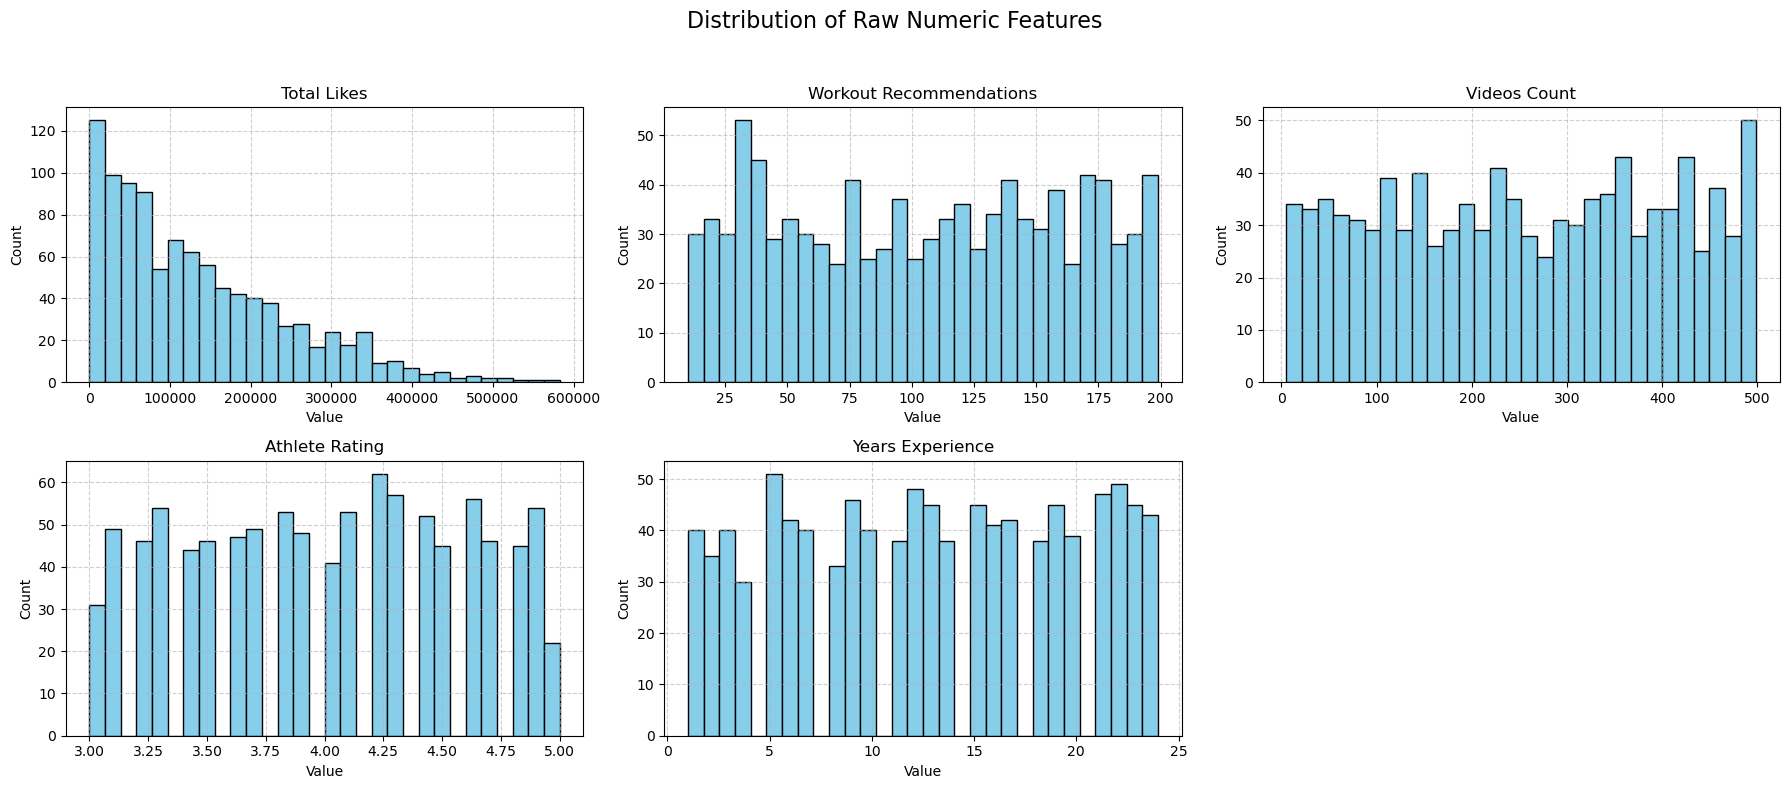

In [5]:
### Histogram to visualize distributions 
import matplotlib.pyplot as plt

numeric_cols = ['total_likes', 'workout_recommendations', 'videos_count',
                'athlete_rating', 'years_experience']

# Create subplots: 2 rows, 3 columns (flexible)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes = axes.flatten()  # flatten to iterate easily

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    ax.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(col.replace('_', ' ').title(), fontsize=12)
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)

# Turn off unused subplot
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Raw Numeric Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for title
plt.show()



In [6]:
### Speciality Count and Normalization
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

log_transform_cols = ['total_likes', 'videos_count']  # Strongly skewed
minmax_only_cols = ['workout_recommendations', 'athlete_rating', 'years_experience']  # Fair distributions

# Initialize scaler 
scaler = MinMaxScaler()

# Log1p transform + MinMax scaling for skewed features
for col in log_transform_cols:
    log_col = f"log1p_{col}"
    norm_col = f"norm_{col}"
    
    df[log_col] = np.log1p(df[col])  # log(1 + x), safe for zeros
    df[[norm_col]] = scaler.fit_transform(df[[log_col]])

# MinMax scaling for normally distributed features
for col in minmax_only_cols:
    norm_col = f"norm_{col}"
    df[[norm_col]] = scaler.fit_transform(df[[col]])

# Process 'specialities' column into a list
df['speciality_list'] = df['specialities'].astype(str).str.split(',').apply(lambda x: [s.strip() for s in x])

# Count frequency of each speciality
all_specialities = [s for sublist in df['speciality_list'].dropna() for s in sublist]
speciality_counts = pd.Series(Counter(all_specialities)).sort_values(ascending=False)

print("\n===== Speciality Frequency =====")
print(speciality_counts)

# Check normalized feature sample
norm_cols = [f'norm_{c}' for c in log_transform_cols + minmax_only_cols]
print("\n===== Normalized Feature Sample =====")
print(df[norm_cols].head())

df.to_csv("/Users/cailingchen/Desktop/Final Project/PT_Dataset_processed.csv", index=False)


===== Speciality Frequency =====
Rehabilitation         143
Cardio                 139
Bodybuilding           138
Yoga                   130
CrossFit               130
Prenatal Fitness       127
Muscle Building        126
Flexibility            126
Powerlifting           126
Functional Training    125
Strength Training      123
Sports-Specific        122
Weight Loss            122
Elderly Fitness        121
Pilates                119
HIIT                   117
dtype: int64

===== Normalized Feature Sample =====
   norm_total_likes  norm_videos_count  norm_workout_recommendations  \
0          0.907070           0.841464                      0.761905   
1          0.792999           0.667708                      0.306878   
2          0.972588           0.992179                      0.174603   
3          0.919498           0.951797                      0.476190   
4          0.786365           0.691923                      0.693122   

   norm_athlete_rating  norm_years_experience  
0

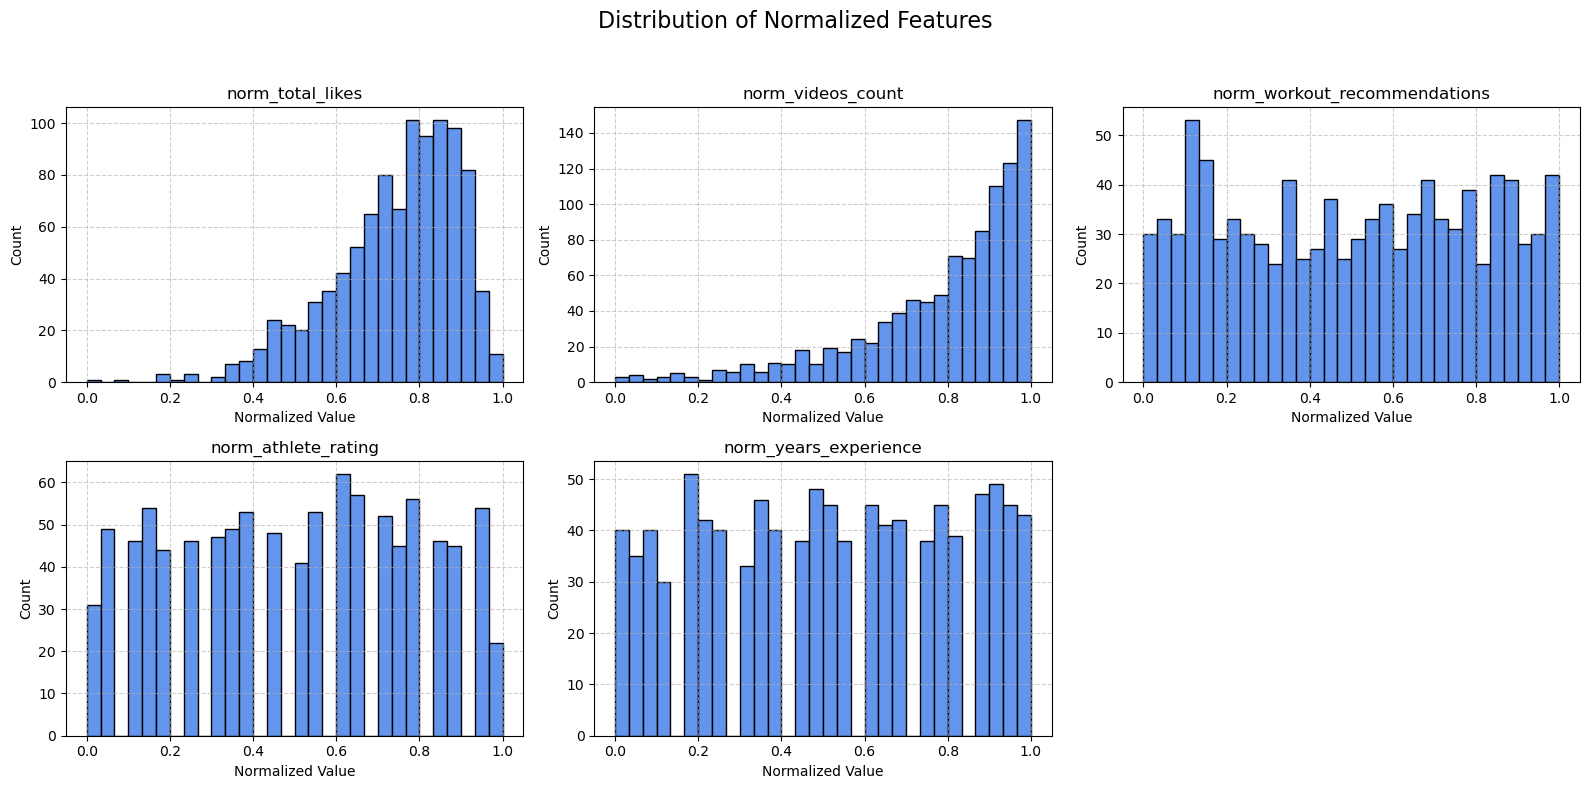

In [7]:
### Visualization of Normalized Features
import matplotlib.pyplot as plt

norm_cols = [f'norm_{c}' for c in log_transform_cols + minmax_only_cols]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(norm_cols):
    ax = axes[i]
    ax.hist(df[col], bins=30, color='cornflowerblue', edgecolor='black')
    ax.set_title(col, fontsize=12)
    ax.set_xlabel('Normalized Value', fontsize=10)
    ax.set_ylabel('Count')
    ax.grid(True, linestyle='--', alpha=0.6)

# Remove empty subplot if needed
for j in range(len(norm_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Normalized Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [8]:
### PCA Score for Cold Start Ranking
from sklearn.decomposition import PCA
import pandas as pd

# Normalized feature columns to be used in PCA
norm_cols = ['norm_total_likes', 'norm_videos_count', 'norm_workout_recommendations', 'norm_athlete_rating', 'norm_years_experience']

# Fit PCA on normalized features
pca = PCA(n_components=1)
pca.fit(df[norm_cols])

# Extract the first principal component's absolute weights and normalize them
raw_weights = abs(pca.components_[0])
pca_weights = raw_weights / raw_weights.sum()

# Compute overall score based on PCA-derived weights
df['score'] = df[norm_cols].dot(pca_weights)

# Display PCA-derived weights for each feature
pca_weight_table = pd.Series(pca_weights, index=norm_cols).sort_values(ascending=False)

print("\nPCA-Derived Feature Weights: ")
print(pca_weight_table)

# Display top-ranked trainers
df_recommend = df.sort_values(by='score', ascending=False).head(10)
print(df_recommend)



PCA-Derived Feature Weights: 
norm_years_experience           0.478558
norm_workout_recommendations    0.268924
norm_athlete_rating             0.192838
norm_videos_count               0.040079
norm_total_likes                0.019600
dtype: float64
     trainer_id         name  videos_count  total_likes  \
289         290  Trainer 290            83        22441   
357         358  Trainer 358           261       187319   
485         486  Trainer 486           488       204850   
648         649  Trainer 649            30         8934   
997         998  Trainer 998           355       407478   
837         838  Trainer 838           453        78568   
173         174  Trainer 174           176        94634   
233         234  Trainer 234           483       204455   
747         748  Trainer 748           489       340642   
105         106  Trainer 106           211        29578   

     workout_recommendations  athlete_rating  years_experience  \
289                      180     

In [9]:
### Blended Cold-Start Ranking with Stratified Specialty Sampling
from collections import defaultdict
import pandas as pd

# Fair sampling from layer with max direction coverage
def sample_with_fair_direction(df_layer, k, used_directions, seed):
    sampled = []
    df_layer = df_layer.sample(frac=1, random_state=seed)  # Shuffle

    for _, row in df_layer.iterrows():
        dirs = set(map(str.strip, str(row['specialities']).split(',')))
        if not dirs & used_directions:
            sampled.append(row)
            used_directions.update(dirs)
        if len(sampled) == k:
            break

    # Allow direction repeats if not enough
    if len(sampled) < k:
        for _, row in df_layer.iterrows():
            if row['trainer_id'] in [r['trainer_id'] for r in sampled]:
                continue
            sampled.append(row)
            if len(sampled) == k:
                break

    return pd.DataFrame(sampled), used_directions

# Cold-start recommendations based on stratified sampling
def generate_cold_start_recommendations(df, user_id, total_n=18):
    df = df.copy()
    df = df.sort_values(by='score', ascending=False).reset_index(drop=True)
    n = len(df)
    layer_size = n // 3
    layers = [
        df.iloc[:layer_size],
        df.iloc[layer_size:2*layer_size],
        df.iloc[2*layer_size:]
    ]
    
    per_layer = total_n // 3
    used_directions = set()
    all_samples = []

    for i, layer_df in enumerate(layers):
        layer_sample, used_directions = sample_with_fair_direction(
            layer_df, per_layer, used_directions,
            seed=abs(hash(f"{user_id}_{i}")) % (2**32)
        )
        all_samples.append(layer_sample)

    final_df = pd.concat(all_samples, ignore_index=True).drop_duplicates('trainer_id')
    return final_df.sort_values(by='score', ascending=False).reset_index(drop=True)


In [10]:
### Test example
user_specific_recommend = generate_cold_start_recommendations(df, user_id='10001')
print("Cold Start recommandation for User_10001:")
print(user_specific_recommend[['trainer_id', 'score', 'specialities']])


Cold Start recommandation for User_10001:
    trainer_id     score                                       specialities
0          542  0.762816  Functional Training, Rehabilitation, Bodybuilding
1          287  0.704475                      CrossFit, Flexibility, Cardio
2          422  0.693981                                    Elderly Fitness
3          260  0.657086                                         HIIT, Yoga
4          850  0.656451                 Sports-Specific, Strength Training
5          457  0.650013                                    Muscle Building
6          577  0.589965                                            Pilates
7           90  0.577270                                        Weight Loss
8          348  0.551350            Cardio, Bodybuilding, Strength Training
9          817  0.541388                                       Powerlifting
10         121  0.510605                                   Prenatal Fitness
11         284  0.459880                      

In [24]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict, Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Load and preprocess trainer data
TRAINER_DATA_PATH = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
df = pd.read_csv(TRAINER_DATA_PATH)

# Basic cleaning
for col in ['athlete_rating', 'total_likes', 'workout_recommendations', 'years_experience', 'videos_count']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Log1p transform + MinMax scaling
log_transform_cols = ['total_likes', 'videos_count']
minmax_only_cols = ['workout_recommendations', 'athlete_rating', 'years_experience']

scaler = MinMaxScaler()
for col in log_transform_cols:
    df[f'log1p_{col}'] = np.log1p(df[col])
    df[f'norm_{col}'] = scaler.fit_transform(df[[f'log1p_{col}']])

for col in minmax_only_cols:
    df[f'norm_{col}'] = scaler.fit_transform(df[[col]])

# Specialities preprocessing
df['speciality_list'] = df['specialities'].astype(str).str.split(',').apply(lambda x: [s.strip() for s in x])
all_specialities = [s for sublist in df['speciality_list'] for s in sublist]
speciality_counts = pd.Series(Counter(all_specialities)).sort_values(ascending=False)

# PCA-based scoring
norm_cols = ['norm_total_likes', 'norm_videos_count', 'norm_workout_recommendations', 'norm_athlete_rating', 'norm_years_experience']
pca = PCA(n_components=1)
pca.fit(df[norm_cols])
pca_weights = abs(pca.components_[0])
pca_weights /= pca_weights.sum()
df['score'] = df[norm_cols].dot(pca_weights)

# Generate synthetic users
NUM_USERS = 100
age_groups = ['young', 'middle', 'senior']
genders = ['Male', 'Female']

goal_mapping = {
    ('young', 'Female'): ['Yoga', 'Pilates', 'WeightLoss', 'HIIT', 'Flexibility', 'StrengthTraining', 'Cardio', 'PrenatalFitness'],
    ('young', 'Male'): ['CrossFit', 'Bodybuilding', 'Powerlifting', 'HIIT', 'Sports-Specific', 'Cardio', 'StrengthTraining'],
    ('middle', 'Female'): ['Pilates', 'Flexibility', 'WeightLoss', 'FunctionalTraining', 'Yoga', 'StrengthTraining'],
    ('middle', 'Male'): ['StrengthTraining', 'FunctionalTraining', 'MuscleBuilding', 'Sports-Specific', 'Cardio', 'HIIT'],
    ('senior', 'Female'): ['ElderlyFitness', 'Flexibility', 'Rehabilitation', 'Cardio', 'Pilates', 'FunctionalTraining'],
    ('senior', 'Male'): ['ElderlyFitness', 'Flexibility', 'Rehabilitation', 'FunctionalTraining', 'Cardio']
}

users = []
for i in range(1, NUM_USERS + 1):
    age_group = random.choice(age_groups)
    gender = random.choice(genders)
    possible_goals = goal_mapping[(age_group, gender)]
    goals = random.sample(possible_goals, k=random.choices([1, 2, 3], weights=[0.3, 0.5, 0.2])[0])

    users.append({
        'user_id': 10000 + i,
        'age_group': age_group,
        'gender': gender,
        'user_goals': ', '.join(goals)
    })

df_users = pd.DataFrame(users)

# Generate user-trainer interactions using cold-start recommendations
NUM_TRAINERS_PER_USER = 18
interactions = []

for _, user in df_users.iterrows():
    user_id = user['user_id']
    shown_trainers = generate_cold_start_recommendations(df, user_id=user_id)

    for _, trainer in shown_trainers.iterrows():
        interactions.append({
            **user,
            'trainer_id': trainer['trainer_id'],
            'trainer_speciality': trainer['specialities'],
            'athlete_rating': trainer['athlete_rating'],
            'total_likes': trainer['total_likes'],
            'videos_count': trainer['videos_count'],
            'workout_recommendations': trainer['workout_recommendations'],
            'years_experience': trainer['years_experience']
        })

df_interact = pd.DataFrame(interactions)

# Matching features
def parse_set(text):
    return set(s.strip() for s in text.split(',') if s.strip())

def compute_overlap(row):
    user_goals = parse_set(row['user_goals'])
    trainer_specs = parse_set(row['trainer_speciality'])
    intersection = user_goals & trainer_specs
    union = user_goals | trainer_specs
    return pd.Series({
        'direction_match': int(len(intersection) > 0),
        'overlap_count': len(intersection),
        'jaccard_score': len(intersection) / len(union) if union else 0
    })

df_overlap = df_interact.apply(compute_overlap, axis=1)
df_interact = pd.concat([df_interact, df_overlap], axis=1)

# Simulate user clicks data
def simulate_click(row):
    base_prob = 0.2
    bonus = 0.25 * row['overlap_count']
    click_prob = min(base_prob + bonus, 0.95)
    return int(random.random() < click_prob)

df_interact['label'] = df_interact.apply(simulate_click, axis=1)

# Save output
OUTPUT_PATH = "/Users/cailingchen/Desktop/Final Project/synthetic_training_data.csv"
df_interact.to_csv(OUTPUT_PATH, index=False)

In [12]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load synthetic training data
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data.csv")

# Apply log transform first to reduce skewness
df['total_likes'] = np.log1p(df['total_likes'])
df['workout_recommendations'] = np.log1p(df['workout_recommendations'])
df['years_experience'] = np.log1p(df['years_experience'])

# Normalize to [0, 1]
scaler = MinMaxScaler()
df[['total_likes', 'workout_recommendations', 'years_experience']] = scaler.fit_transform(
    df[['total_likes', 'workout_recommendations', 'years_experience']]
)

# Define features and labels
features = [
    'jaccard_score',
    'overlap_count',
    'direction_match',
    'athlete_rating',
    'total_likes',
    'workout_recommendations',
    'years_experience'
]
label_col = 'label'
group_col = 'user_id'

X = df[features]
y = df[label_col]

# Group information for ranking (size of each user group)
group_sizes = df.groupby(group_col).size().tolist()

# Create LightGBM Dataset
train_data = lgb.Dataset(X, label=y, group=group_sizes)

# Define LambdaRank parameters
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [5, 10],
    'learning_rate': 0.05,
    'num_leaves': 15,
    'min_data_in_leaf': 20,
    'verbose': -1
}

# Train LambdaRank model
ranker = lgb.train(
    params,
    train_data,
    num_boost_round=100
)

# Save model 
ranker.save_model("/Users/cailingchen/Desktop/Final Project/lambdarank_model.txt")


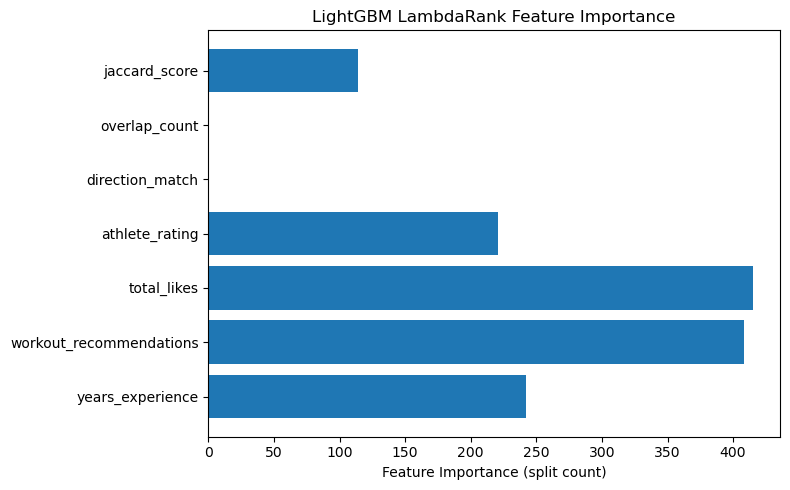

In [13]:
import matplotlib.pyplot as plt
import lightgbm as lgb

model = lgb.Booster(model_file='/Users/cailingchen/Desktop/Final Project/lambdarank_model.txt')

importance = model.feature_importance(importance_type='split')
feature_names = model.feature_name()

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importance)
plt.xlabel("Feature Importance (split count)")
plt.title("LightGBM LambdaRank Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
import lightgbm as lgb

df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data.csv")

# Load model
model = lgb.Booster(model_file="/Users/cailingchen/Desktop/Final Project/lambdarank_model.txt")

# Define feature columns used for the model
feature_cols = ['jaccard_score', 'overlap_count', 'direction_match',
                'athlete_rating', 'total_likes', 'workout_recommendations', 'years_experience']

# Store all user sorting results
all_reranked = []

# Rerank by user group
for user_id, user_df in df.groupby("user_id"):
    X_user = user_df[feature_cols]
    scores = model.predict(X_user)

    user_df = user_df.copy()
    user_df['predicted_score'] = scores

    user_df = user_df.sort_values(by='predicted_score', ascending=False).reset_index(drop=True)
    all_reranked.append(user_df)

# Merge all users' recommendation results
final_reranked_df = pd.concat(all_reranked, ignore_index=True)

# Save to CSV
final_reranked_df.to_csv("/Users/cailingchen/Desktop/Final Project/Personalized_Reranked.csv", index=False)

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import ndcg_score

# Load reranked data with predicted scores and true labels
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/Personalized_Reranked.csv")

# Ensure required columns are present
assert {'user_id', 'label', 'predicted_score'}.issubset(df.columns)

# Store NDCG@5 scores per user
ndcg_scores = []

# Evaluate NDCG@5 for each user group
for user_id, group in df.groupby("user_id"):
    y_true = group["label"].values.reshape(1, -1)         # true relevance
    y_score = group["predicted_score"].values.reshape(1, -1)  # predicted score

    # Only compute NDCG if there's at least one relevant item
    if y_true.sum() > 0:
        ndcg = ndcg_score(y_true, y_score, k=5)
        ndcg_scores.append(ndcg)

# Report average NDCG@5 across all users
mean_ndcg_5 = np.mean(ndcg_scores)
print(f"Mean NDCG@5: {mean_ndcg_5:.4f}")


Mean NDCG@5: 0.3247


In [16]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load synthetic training data
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data.csv")

# Apply log transform first to reduce skewness
df['total_likes'] = np.log1p(df['total_likes'])
df['workout_recommendations'] = np.log1p(df['workout_recommendations'])
df['years_experience'] = np.log1p(df['years_experience'])

# Normalize to [0, 1]
scaler = MinMaxScaler()
df[['total_likes', 'workout_recommendations', 'years_experience']] = scaler.fit_transform(
    df[['total_likes', 'workout_recommendations', 'years_experience']]
)

# Define features and labels
features = [
    'jaccard_score',
    'overlap_count',
    'direction_match',
    'athlete_rating',
    'total_likes',
    'workout_recommendations',
    'years_experience'
]
label_col = 'label'
group_col = 'user_id'

X = df[features]
y = df[label_col]

# Group information for ranking (size of each user group)
group_sizes = df.groupby(group_col).size().tolist()

# Create LightGBM Dataset
train_data = lgb.Dataset(X, label=y, group=group_sizes)

# Define LambdaRank parameters
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [10],
    'learning_rate': 0.05,
    'num_leaves': 15,
    'min_data_in_leaf': 20,
    'verbose': -1
}

# Train LambdaRank model
ranker = lgb.train(
    params,
    train_data,
    num_boost_round=300
)

# Save model 
ranker.save_model("/Users/cailingchen/Desktop/Final Project/lambdarank_model_2.txt")


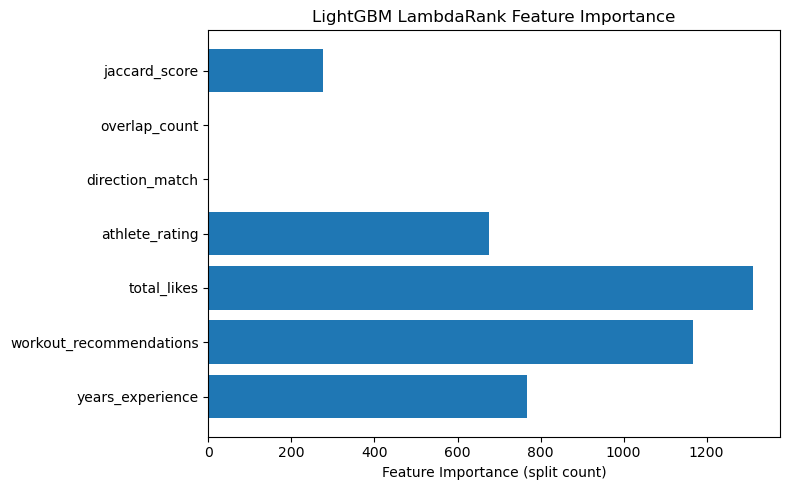

In [17]:
import matplotlib.pyplot as plt
import lightgbm as lgb

model = lgb.Booster(model_file='/Users/cailingchen/Desktop/Final Project/lambdarank_model_2.txt')

importance = model.feature_importance(importance_type='split')
feature_names = model.feature_name()

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importance)
plt.xlabel("Feature Importance (split count)")
plt.title("LightGBM LambdaRank Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import lightgbm as lgb

df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data.csv")

# Load model
model = lgb.Booster(model_file="/Users/cailingchen/Desktop/Final Project/lambdarank_model_2.txt")

# Define feature columns used for the model
feature_cols = ['jaccard_score', 'overlap_count', 'direction_match',
                'athlete_rating', 'total_likes', 'workout_recommendations', 'years_experience']

# Store all user sorting results
all_reranked = []

# Rerank by user group
for user_id, user_df in df.groupby("user_id"):
    X_user = user_df[feature_cols]
    scores = model.predict(X_user)

    user_df = user_df.copy()
    user_df['predicted_score'] = scores

    user_df = user_df.sort_values(by='predicted_score', ascending=False).reset_index(drop=True)
    all_reranked.append(user_df)

# Merge all users' recommendation results
final_reranked_df = pd.concat(all_reranked, ignore_index=True)

# Save to CSV
final_reranked_df.to_csv("/Users/cailingchen/Desktop/Final Project/Personalized_Reranked_2.csv", index=False)

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import ndcg_score

# Load reranked data with predicted scores and true labels
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/Personalized_Reranked.csv")

# Ensure required columns are present
assert {'user_id', 'label', 'predicted_score'}.issubset(df.columns)

# Store NDCG@5 scores per user
ndcg_scores = []

# Evaluate NDCG@5 for each user group
for user_id, group in df.groupby("user_id"):
    y_true = group["label"].values.reshape(1, -1)         # true relevance
    y_score = group["predicted_score"].values.reshape(1, -1)  # predicted score

    # Only compute NDCG if there's at least one relevant item
    if y_true.sum() > 0:
        ndcg = ndcg_score(y_true, y_score, k=10)
        ndcg_scores.append(ndcg)

# Report average NDCG@5 across all users
mean_ndcg_10 = np.mean(ndcg_scores)
print(f"Mean NDCG@5: {mean_ndcg_10:.4f}")


Mean NDCG@5: 0.4432


In [20]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load synthetic training data
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data.csv")

# Replace total_likes with average likes per video
df["avg_likes_per_video"] = df["total_likes"] / (df["workout_recommendations"] + 1e-5)  # avoid division by 0

# Apply log1p transform to reduce skewness
df["avg_likes_per_video"] = np.log1p(df["avg_likes_per_video"])
df["workout_recommendations"] = np.log1p(df["workout_recommendations"])
df["years_experience"] = np.log1p(df["years_experience"])

# Normalize selected features to [0, 1]
scaler = MinMaxScaler()
df[["avg_likes_per_video", "workout_recommendations", "years_experience"]] = scaler.fit_transform(
    df[["avg_likes_per_video", "workout_recommendations", "years_experience"]]
)

# Define features and labels
features = [
    'jaccard_score',
    'overlap_count',
    'direction_match',
    'athlete_rating',
    'avg_likes_per_video',
    'workout_recommendations',
    'years_experience'
]
label_col = 'label'
group_col = 'user_id'

X = df[features]
y = df[label_col]

# Compute group sizes per user
group_sizes = df.groupby(group_col).size().tolist()

# Prepare LightGBM dataset
train_data = lgb.Dataset(X, label=y, group=group_sizes)

# LambdaRank parameters
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [10],
    'learning_rate': 0.05,
    'num_leaves': 15,
    'min_data_in_leaf': 20,
    'verbose': -1
}

# Train model
ranker = lgb.train(
    params,
    train_data,
    num_boost_round=300
)

# Save model
ranker.save_model("/Users/cailingchen/Desktop/Final Project/lambdarank_model_3.txt")


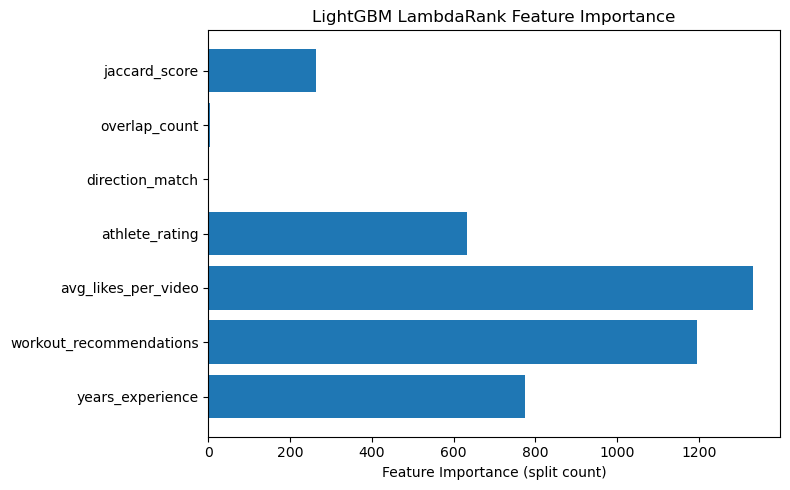

In [21]:
import matplotlib.pyplot as plt
import lightgbm as lgb

model = lgb.Booster(model_file='/Users/cailingchen/Desktop/Final Project/lambdarank_model_3.txt')

importance = model.feature_importance(importance_type='split')
feature_names = model.feature_name()

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importance)
plt.xlabel("Feature Importance (split count)")
plt.title("LightGBM LambdaRank Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
import lightgbm as lgb

df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data.csv")

# Load model
model = lgb.Booster(model_file="/Users/cailingchen/Desktop/Final Project/lambdarank_model_3.txt")

# Define feature columns used for the model
feature_cols = ['jaccard_score', 'overlap_count', 'direction_match',
                'athlete_rating', 'total_likes', 'workout_recommendations', 'years_experience']

# Store all user sorting results
all_reranked = []

# Rerank by user group
for user_id, user_df in df.groupby("user_id"):
    X_user = user_df[feature_cols]
    scores = model.predict(X_user)

    user_df = user_df.copy()
    user_df['predicted_score'] = scores

    user_df = user_df.sort_values(by='predicted_score', ascending=False).reset_index(drop=True)
    all_reranked.append(user_df)

# Merge all users' recommendation results
final_reranked_df = pd.concat(all_reranked, ignore_index=True)

# Save to CSV
final_reranked_df.to_csv("/Users/cailingchen/Desktop/Final Project/Personalized_Reranked_3.csv", index=False)

In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import ndcg_score

# Load reranked data with predicted scores and true labels
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/Personalized_Reranked_3.csv")

# Ensure required columns are present
assert {'user_id', 'label', 'predicted_score'}.issubset(df.columns)

# Store NDCG@5 scores per user
ndcg_scores = []

# Evaluate NDCG@5 for each user group
for user_id, group in df.groupby("user_id"):
    y_true = group["label"].values.reshape(1, -1)         # true relevance
    y_score = group["predicted_score"].values.reshape(1, -1)  # predicted score

    # Only compute NDCG if there's at least one relevant item
    if y_true.sum() > 0:
        ndcg = ndcg_score(y_true, y_score, k=10)
        ndcg_scores.append(ndcg)

# Report average NDCG@5 across all users
mean_ndcg_10 = np.mean(ndcg_scores)
print(f"Mean NDCG@5: {mean_ndcg_10:.4f}")


Mean NDCG@5: 0.5082
